<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg" />
</center> 
     
## <center>  [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

#### <center> Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko) 

## <center> A disciplined approach to cross-validation in a Kaggle (Inclass) competition 


Here we'll show how to progress with feature engineering in the [Alice](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) competition, we'll simulate some mistakes that can be done, show how to interpret model weights with [eli5](https://github.com/TeamHG-Memex/eli5), and discuss our validation scheme even further. Prerequisites: [Alice - logistic regression baseline](https://www.kaggle.com/kashnitsky/alice-logistic-regression-baseline) and [Correct time-aware cross-validation scheme](https://www.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme).
 
 
Plan:
 - [Submission 1: "Bag of sites" baseline](#Submission-1:-"Bag-of-sites"-baseline)
 - [Submission 2: Coming up with time features via EDA](#Submission-2:-Coming-up-with-time-features-via-EDA)
 - [Submission 3: Example of overfitting](#Submission-3:-Example-of-overfitting)
 - [Submissions 4 and 5: The importance of feature scaling](#Submissions-4-and-5:-The-importance-of-feature-scaling)
 - [Submission 6: Adding more time features](#Submission-6:-Adding-more-time-features)
 - [Submission-7: Tuning-params](#Submission-7:-Tuning-params)
 - [Analyzing submission history](#Analyzing-submission-history)
 - [Conclusions](#Conclusions)

In [2]:
# Import libraries and set desired options
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack
# !pip install eli5
import eli5
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display_html

C:\Users\Aleksey\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
PATH_TO_DATA = '../input/'
SEED = 17

## Submission 1: "Bag of sites" baseline

**We'll start with basic site features, applying the "bag of words" approach. Here we read training and test sets, sort train set by session start time.**

In [8]:
def prepare_sparse_features(path_to_train, path_to_test, path_to_site_dict,
                           vectorizer_params):
    times = ['time%s' % i for i in range(1, 11)]
    train_df = pd.read_csv(path_to_train,
                       index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_to_test,
                      index_col='session_id', parse_dates=times)

    # Sort the data by time
    train_df = train_df.sort_values(by='time1')
    
    # read site -> id mapping provided by competition organizers 
    with open(path_to_site_dict, 'rb') as f:
        site2id = pickle.load(f)
    # create an inverse id _> site mapping
    id2site = {v:k for (k, v) in site2id.items()}
    # we treat site with id 0 as "unknown"
    id2site[0] = 'unknown'
    
    # Transform data into format which can be fed into TfidfVectorizer
    # This time we prefer to represent sessions with site names, not site ids. 
    # It's less efficient but thus it'll be more convenient to interpret model weights.
    sites = ['site%s' % i for i in range(1, 11)]
    train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    # we'll tell TfidfVectorizer that we'd like to split data by whitespaces only 
    # so that it doesn't split by dots (we wouldn't like to have 'mail.google.com' 
    # to be split into 'mail', 'google' and 'com')
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_sessions)
    X_test = vectorizer.transform(test_sessions)
    y_train = train_df['target'].astype('int').values
    
    # My df for EDA and other
    X_train_poor = train_df.copy()
    X_train_poor[sites] = X_train_poor[sites].fillna(0)
    # нужно ли заполнять NaT в 0? Не уверен
    # times = ['time%s' % i for i in range(1, 11)]
    # X_train_poor[times] = X_train_poor[times].fillna(0)
    
    
    # we'll need site visit times for further feature engineering
    train_times, test_times = train_df[times], test_df[times]
    
    return X_train, X_test, y_train, vectorizer, train_times, test_times, X_train_poor

**By running the above function, we get sparse train and test matrices (`X_train_sites`, `X_test_sites`), vector of train targets `y_train` (0's and 1's - whether a session belongs to Alice or not), an instance of `TfidfVectorizer` (we'll need site name from it) and site visit times both for training and test sets, for further feature engineering. Go back to the function defined above, read comments, and experiment yourself to understand what we've done here.**

In [9]:
%%time
X_train_sites, X_test_sites, y_train, vectorizer, train_times, test_times, X_train_poor = prepare_sparse_features(
    path_to_train=os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
    path_to_test=os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
    path_to_site_dict=os.path.join(PATH_TO_DATA, 'site_dic.pkl'),
    vectorizer_params={'ngram_range': (1, 5), 
                       'max_features': 50000,
                       'tokenizer': lambda s: s.split()}
)

Wall time: 47.2 s


In [48]:
train_times.head()

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
session_id,,,,,,,,,,
21669,2013-01-12 08:05:57,2013-01-12 08:05:57,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
54843,2013-01-12 08:37:23,2013-01-12 08:37:23,2013-01-12 09:07:07,2013-01-12 09:07:09,NaT,NaT,NaT,NaT,NaT,NaT
77292,2013-01-12 08:50:13,2013-01-12 08:50:14,2013-01-12 08:50:15,2013-01-12 08:50:15,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,2013-01-12 08:50:17
114021,2013-01-12 08:50:17,2013-01-12 08:50:17,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:20
146670,2013-01-12 08:50:20,2013-01-12 08:50:20,2013-01-12 08:50:20,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:22,2013-01-12 08:50:22,2013-01-12 08:50:22


In [10]:
print(X_train_sites.shape, X_test_sites.shape)

(253561, 50000) (82797, 50000)


**These are basic features - sequences of visited web-sites.**

In [11]:
vectorizer.get_feature_names()[:10]

['0.academia-assets.com',
 '0.docs.google.com',
 '0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.drive.google.com',
 '0.docs.google.com 0.docs.google.com apis.google.com',
 '0.docs.google.com 0.docs.google.com docs.google.com',
 '0.docs.google.com 0.drive.google.com',
 '0.docs.google.com 0.drive.google.com 0.docs.google.com']

In [12]:
vectorizer.get_feature_names()[10000:10010]

['de-img3.ask.fm',
 'de-img4.ask.fm',
 'de.tynt.com',
 'de.tynt.com api.adyoulike.com',
 'de.tynt.com api.adyoulike.com syndication.twitter.com',
 'de.tynt.com api.adyoulike.com twitter.com',
 'de.tynt.com platform.twitter.com',
 'de.tynt.com platform.twitter.com twitter.com',
 'de.tynt.com premium.hi-mediaserver.com',
 'de.tynt.com syndication.twitter.com']

**We'll be performing time series cross-validation, see [the previous kernel](https://www.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme) for an explanation.**

In [13]:
time_split = TimeSeriesSplit(n_splits=10)

**Perform time series cross-validation with logistic regression.**

In [14]:
logit = LogisticRegression(C=1, random_state=SEED, solver='liblinear')

In [15]:
%%time

cv_scores1 = cross_val_score(logit, X_train_sites, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=10) # hangs with n_jobs > 1, and locally this runs much faster

Wall time: 51.8 s


In [16]:
cv_scores1, cv_scores1.mean()

(array([0.83124023, 0.65993466, 0.85673565, 0.92824237, 0.84779639,
        0.88954599, 0.88829128, 0.8771044 , 0.92023038, 0.92624225]),
 0.86253636132667)

**Train logistic regression with all training data**

In [17]:
logit.fit(X_train_sites, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

**Display model weights with eli5**

In [18]:
eli5.show_weights(estimator=logit, 
                  feature_names=vectorizer.get_feature_names(), top=30)

Weight?,Feature
+5.880,youwatch.org
+5.380,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.222,fr.glee.wikia.com
+5.114,vk.com
+4.875,www.info-jeunes.net
+4.499,www.banque-chalus.fr
+4.220,www.express.co.uk
+4.147,www.audienceinsights.net
+4.089,www.melty.fr
+4.003,glee.hypnoweb.net


**Now we see which sites are descriptive of Alice. At the same time we notice that Alice doesn't use Gmail and Google Plus. Let's make predictions for test set and form a submission file.**

In [334]:
# A helper function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [335]:
logit_test_pred = logit.predict_proba(X_test_sites)[:, 1]
write_to_submission_file(logit_test_pred, 'subm1.csv') # 0.91807

**We are going to repeat these steps several more times. It's a nice practice to substitute repeated chunks of code with function calls. So let's write a function which performs cross-validation, model training, displaying feature importance, making predictions for a test set and forming a submission file.**

In [19]:
def train_and_predict(model, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=None, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission.csv'):
    
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                            scoring=scoring, n_jobs=4)
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
    
    if new_feature_names:
        all_feature_names = site_feature_names + new_feature_names 
    else: 
        all_feature_names = site_feature_names
    
    display_html(eli5.show_weights(estimator=model, 
                  feature_names=all_feature_names, top=top_n_features_to_show))
    
    if new_feature_names:
        print('New feature weights:')
    
        print(pd.DataFrame({'feature': new_feature_names, 
                        'coef': model.coef_.flatten()[-len(new_feature_names):]}))
    
    test_pred = model.predict_proba(X_test)[:, 1]
    write_to_submission_file(test_pred, submission_file_name) 
    
    return cv_scores

In [337]:
cv_scores1 = train_and_predict(model=logit, X_train=X_train_sites, y_train=y_train, 
                  X_test=X_test_sites, site_feature_names=vectorizer.get_feature_names(),              
                  cv=time_split, submission_file_name='subm1.csv')

CV scores [0.83124023 0.65993466 0.85673565 0.92824237 0.84779639 0.88954599
 0.88829128 0.8771044  0.92023038 0.92624225]
CV mean: 0.86253636132667, CV std: 0.07455682064410078


Weight?,Feature
+5.880,youwatch.org
+5.380,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.222,fr.glee.wikia.com
+5.114,vk.com
+4.875,www.info-jeunes.net
+4.499,www.banque-chalus.fr
+4.220,www.express.co.uk
+4.147,www.audienceinsights.net
+4.089,www.melty.fr
+4.003,glee.hypnoweb.net


## Submission 2: Coming up with time features via EDA
Here we'll build just a few plots to motivate feature engineering. While competing, you'll need to create much more plots and build more features based on your observations. Take a look at [Kernels](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/kernels?sortBy=voteCount&group=everyone&pageSize=20&competitionId=7173) for this competition, eg. at [this "Initial EDA"](https://www.kaggle.com/adityaecdrid/initial-eda). You can do much more with sites, but let's switch to site visit times.

We've got an intuition: different people might prefer to visit (even the same) sites at *different* times of the day. Let's first draw the distribution of all session start hours. 

In [338]:
session_start_hour = train_times['time1'].apply(lambda ts: ts.hour).values
session_start_hour.shape

(253561,)

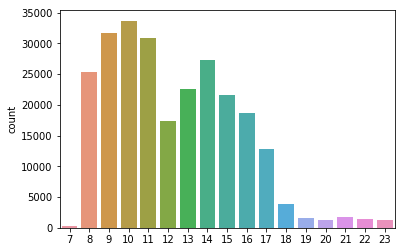

In [339]:
sns.countplot(session_start_hour);

Now the same separately for Alice and everybody else.

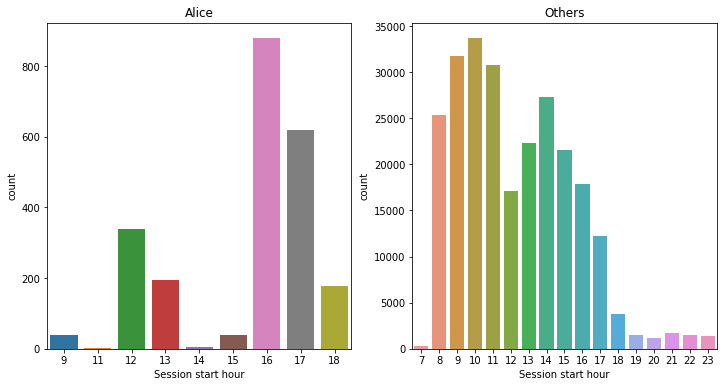

In [340]:
plt.subplots(1, 2, figsize = (12, 6)) 

plt.subplot(1, 2, 1)
sns.countplot(session_start_hour[y_train == 1])
plt.title("Alice")
plt.xlabel('Session start hour')
          
plt.subplot(1, 2, 2)
sns.countplot(session_start_hour[y_train == 0])
plt.title('Others')
plt.xlabel('Session start hour');

Now we definitely see that Alice mostly prefers 4-5 pm for browsing. So let's create features 'morning', 'day' and 'evening' and 'night'. Separators between these times of the day will be almost arbitrary: 0 am, 7 am, 12 am, and 7 pm. However, you can tune this.

In [341]:
morning = ((session_start_hour >= 7) & (session_start_hour <= 11)).astype('int')
day = ((session_start_hour >= 12) & (session_start_hour <= 18)).astype('int')
evening = ((session_start_hour >= 19) & (session_start_hour <= 23)).astype('int')
night = ((session_start_hour >= 0) & (session_start_hour <= 6)).astype('int')

In [342]:
pd.crosstab([morning, day, evening, night], y_train, rownames=['morning', 'day', 'evening', 'night'])

col_0                           0     1
morning day evening night              
0       0   1       0        7251     0
        1   0       0      122129  2256
1       0   0       0      121884    41

**Let's create a separate function to add new features (this will keep the code cleaner). To demonstrate possible overfitting, we'll keep a flag - whether to add an `hour` feature or not.**

In [23]:
def add_time_features(times, X_train, add_hour=True, poor_df = False):
    hour = times['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int').values.reshape(-1, 1)
    day = ((hour >= 12) & (hour <= 18)).astype('int').values.reshape(-1, 1)
    evening = ((hour >= 19) & (hour <= 23)).astype('int').values.reshape(-1, 1)
    night = ((hour >= 0) & (hour <=6)).astype('int').values.reshape(-1, 1)
    
    objects_to_hstack = [X_train, morning, day, evening, night]
    feature_names = ['morning', 'day', 'evening', 'night']
    
    if add_hour:
        # we'll do it right and scale hour dividing by 24
        objects_to_hstack.append(hour.values.reshape(-1, 1) / 24)
        feature_names.append('hour')
    if poor_df==False:
        X = hstack(objects_to_hstack)
    else:
        X = X_train.copy()
        X['hour'] = X['time1'].apply(lambda ts: ts.hour)
        X['morning'] = X['hour'].apply(lambda h:(h >= 7 & h <= 11)).astype('int')
        X['day'] = X['hour'].apply(lambda h:(h >= 12 & h <= 18)).astype('int')
        X['evening'] = X['hour'].apply(lambda h:(h >= 19 & h <= 23)).astype('int')
        X['night'] = X['hour'].apply(lambda h:(h >= 0 & h <=6)).astype('int')
        if add_hour==False:
            X = X.drop(['hour'], axis=1)
    return X, feature_names

In [344]:
%%time
X_train_with_times1, new_feat_names = add_time_features(train_times, X_train_sites)
X_test_with_times1, _ = add_time_features(test_times, X_test_sites)

Wall time: 2.59 s


In [345]:
X_train_with_times1.shape, X_test_with_times1.shape

((253561, 50005), (82797, 50005))

**Performing time series cross-validation, we see an improvement in ROC AUC.**

In [346]:
cv_scores2 = train_and_predict(model=logit, X_train=X_train_with_times1, y_train=y_train, 
                               X_test=X_test_with_times1, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names,
                               cv=time_split, submission_file_name='subm2.csv')

CV scores [0.81904687 0.78705941 0.94510729 0.96676436 0.88993687 0.96695898
 0.91829701 0.93962258 0.96595914 0.96884529]
CV mean: 0.9167597805328503, CV std: 0.062106373018706564


Weight?,Feature
+7.046,hour
+5.148,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.986,www.express.co.uk
+4.833,youwatch.org
+4.804,www.info-jeunes.net
+4.679,vk.com
+4.567,www.melty.fr
+4.330,fr.glee.wikia.com
+4.100,www.audienceinsights.net
+3.962,www.banque-chalus.fr


New feature weights:
   feature      coef
0  morning -2.904833
1      day -0.613841
2  evening -5.069779
3    night  0.000000
4     hour  7.045650


**We see an improvement almost for all folds as compared to the results of previous cross-validation.**

In [347]:
# print('new pred: ',cv_scores2, 'old pred: ', cv_scores2)
cv_scores2 > cv_scores1

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

## Submission 3: Example of overfitting

**Making a new submission, we notice a leaderboard score improvement as well (0.91807 ->  0.93089). Looks good as compared to sites only. But we might be a bit wary that feature `hour` gets such a big weight. Let's try the same features but without `hour`.**

In [348]:
%%time
X_train_with_times2, new_feat_names = add_time_features(train_times, X_train_sites, add_hour=False)
X_test_with_times2, _ = add_time_features(test_times, X_test_sites, add_hour=False)


cv_scores3 = train_and_predict(model=logit, X_train=X_train_with_times2, y_train=y_train, 
                               X_test=X_test_with_times2, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names,
                               cv=time_split, submission_file_name='subm3.csv')

CV scores [0.88170019 0.81426901 0.91861447 0.96171465 0.91532958 0.95227476
 0.92804771 0.94016178 0.94665449 0.95277436]
CV mean: 0.9211540988793054, CV std: 0.042064219951803226


Weight?,Feature
+5.218,youwatch.org
+5.093,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.971,www.express.co.uk
+4.914,vk.com
+4.640,fr.glee.wikia.com
+4.542,www.info-jeunes.net
+4.382,www.melty.fr
+4.183,www.audienceinsights.net
+4.104,www.banque-chalus.fr
+3.823,r4---sn-gxo5uxg-jqbe.googlevideo.com


New feature weights:
   feature      coef
0  morning -3.211819
1      day  0.526636
2  evening -2.721465
3    night  0.000000
Wall time: 40.4 s


**Now cross-validation is much more stable. 3rd CV results are better for each and every fold as compared to the first ones. And actually the situation is better than with the `hour` feature for 5 folds out of 10, but in such case we'll prefer a model with less variation of CV results, i.e. the last one.**

In [349]:
cv_scores3 > cv_scores1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [350]:
cv_scores3 > cv_scores2

array([ True,  True, False, False,  True, False,  True,  True, False,
       False])

Making a new submission we get... Wow! **0.94535** Public LB score instead of **0.93089** when adding the `hour` feature. We were right, the `hour` feature leads to overfitting, and it's better not to add it. 

## Submissions 4 and 5: The importance of feature scaling

**Now we'll add a new feature: session duration. But beware: first we'll do it in an incorrect way, then we'll correct ourselves.**

In [24]:
def add_session_duration_incorrect(times, X_sparse):
    new_feat = (times.max(axis=1) - times.min(axis=1)).astype('timedelta64[ms]').astype(int)
    return hstack([X_sparse, new_feat.values.reshape(-1, 1)])

In [352]:
X_train_with_time_incorrect = add_session_duration_incorrect(train_times, X_train_with_times2)
X_test_with_time_incorrect = add_session_duration_incorrect(test_times, X_test_with_times2)

In [353]:
cv_scores4 = train_and_predict(model=logit, X_train=X_train_with_time_incorrect, y_train=y_train, 
                               X_test=X_test_with_time_incorrect, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'],
                               cv=time_split, submission_file_name='subm4.csv')

CV scores [0.57324417 0.6057354  0.59064502 0.55137641 0.63484782 0.66004053
 0.74572105 0.67174803 0.61461151 0.61200149]
CV mean: 0.6259971432088414, CV std: 0.05291615658123371


y=1
 
 

top features
 
 
 
 
 
 
 
 Weight ? 
 
 
 Feature 
 
 
 
 
 
 
 
 
 … 1784 more positive … 
 
 
 

 
 
 
 … 48191 more negative … 
 
 
 
 
 
 
 -0.009
 
 
 khms1.google.fr
 
 
 
 
 
 
 -0.009
 
 
 ts2.mm.bing.net
 
 
 
 
 
 
 -0.010
 
 
 s.ytimg.com
 
 
 
 
 
 
 -0.010
 
 
 www.youtube.com
 
 
 
 
 
 
 -0.010
 
 
 mail.google.com
 
 
 
 
 
 
 -0.011
 
 
 clients1.google.com
 
 
 
 
 
 
 -0.012
 
 
 mts1.google.com
 
 
 
 
 
 
 -0.012
 
 
 ajax.googleapis.com
 
 
 
 
 
 
 -0.012
 
 
 twitter.com
 
 
 
 
 
 
 -0.012
 
 
 mts0.google.com
 
 
 
 
 
 
 -0.014
 
 
 accounts.google.com
 
 
 
 
 
 
 -0.015
 
 
 ts1.mm.bing.net
 
 
 
 
 
 
 -0.015
 
 
 connect.facebook.net
 
 
 
 
 
 
 -0.019
 
 
 www.google.fr
 
 
 
 
 
 
 -0.021
 
 
 s-static.ak.facebook.com
 
 
 
 
 
 
 -0.022
 
 
 static.ak.facebook.com
 
 
 
 
 
 
 -0.023
 
 
 www.bing.com
 
 
 
 
 
 
 -0.024
 
 
 apis.google.com
 
 
 
 
 
 
 -0.025
 
 
 www.google.com
 
 
 
 
 
 
 -0.026
 
 
 platform.twitter.com
 
 
 
 
 
 
 -0.038
 
 
 www.facebook.com
 
 
 
 
 
 
 -0.044
 
 
 unknown unknown unknown unknown unknown
 
 
 
 
 
 
 -0.045
 
 
 evening
 
 
 
 
 
 
 -0.054
 
 
 unknown unknown unknown unknown
 
 
 
 
 
 
 -0.065
 
 
 unknown unknown unknown
 
 
 
 
 
 
 -0.075
 
 
 unknown unknown
 
 
 
 
 
 
 -0.084
 
 
 unknown
 
 
 
 
 
 
 -0.603
 
 
 day
 
 
 
 
 
 
 -0.690
 
 
 morning
 
 
 
 
 
 
 -1.337
 
 
 <BIAS>

New feature weights:
         feature      coef
0        morning -0.689711
1            day -0.602607
2        evening -0.045053
3          night  0.000000
4  sess_duration -0.000044


**What's the reason of such a deterioration?**
Obvious! The new feature is session duration in milliseconds, it's maximal value is very high (check it). We need to either scale a new feature or, alternatively, measure it in some different units. You can check that actually, measuring it in seconds (rather than milliseconds will do). But instead we'll perform feature scaling, it's a more universal technique to apply for numeric features which can take high values.

In [354]:
train_durations = (train_times.max(axis=1) - train_times.min(axis=1)).astype('timedelta64[ms]').astype(int)
test_durations = (test_times.max(axis=1) - test_times.min(axis=1)).astype('timedelta64[ms]').astype(int)

scaler = StandardScaler()
train_dur_scaled = scaler.fit_transform(train_durations.values.reshape(-1, 1))
test_dur_scaled = scaler.transform(test_durations.values.reshape(-1, 1))

In [355]:
X_train_with_time_correct = hstack([X_train_with_times2, train_dur_scaled])
X_test_with_time_correct = hstack([X_test_with_times2, test_dur_scaled])

In [356]:
cv_scores5 = train_and_predict(model=logit, X_train=X_train_with_time_correct, y_train=y_train, 
                               X_test=X_test_with_time_correct, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'],
                               cv=time_split, submission_file_name='subm5.csv')

CV scores [0.86809822 0.81821851 0.91950303 0.96171682 0.91593618 0.95368736
 0.93027565 0.94128874 0.94847477 0.95287335]
CV mean: 0.9210072628830739, CV std: 0.04287806229141564


Weight?,Feature
+5.212,youwatch.org
+5.058,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.974,vk.com
+4.969,www.express.co.uk
+4.617,fr.glee.wikia.com
+4.532,www.info-jeunes.net
+4.363,www.melty.fr
+4.148,www.banque-chalus.fr
+4.146,www.audienceinsights.net
+3.792,r4---sn-gxo5uxg-jqbe.googlevideo.com


New feature weights:
         feature      coef
0        morning -3.230468
1            day  0.509579
2        evening -2.722820
3          night  0.000000
4  sess_duration -0.241711


**New model predicts better on 9 folds out of 10 as compared to the model with sites and time features. Submitting yields 0.94630 Public LB ROC AUC.**

In [357]:
cv_scores5 > cv_scores3

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

## Submission 6: Adding more time features

In a real competition it's very important to keep track of Public Kernels and borrow some ideas form them.  For instance, we can explore [this Kernel](https://www.kaggle.com/hakeydotcom/additional-time-features-and-logit) and decide to add to features: day of week and month. In this case it's easy to come up to such features on your own, but still typically there's a lot to find out in Kernels.  

In [25]:
def add_day(times, X_sparse, poor_df = False):
    day_of_week = times['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
    
    objects_to_hstack = [X_sparse, day_of_week]
    feature_names = ['day_of_week']
    if poor_df:
        X = X_sparse.copy()
        X['day_of_week'] = times['time1'].apply(lambda t: t.weekday())
    else:
        X = hstack(objects_to_hstack)
    return X, feature_names

In [26]:
def add_month(times, X_sparse, poor_df = False):
    month = times['time1'].apply(lambda t: t.month).values.reshape(-1, 1) 
    # linear trend: time in a form YYYYMM, we'll divide by 1e5 to scale this feature 
    year_month = times['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1) / 1e5
    
    objects_to_hstack = [X_sparse, month, year_month]
    feature_names = ['month', 'year_month']
    if poor_df:
        X = X_sparse.copy()
        X['month'] =  X['time1'].apply(lambda t: t.month)
        X['year_month'] = X['time1'].apply(lambda t: 100 * t.year + t.month)
    else:
        X = hstack(objects_to_hstack)
    return X, feature_names

In [360]:
X_train_prefinal, premore_feat_names = add_month(train_times, X_train_with_time_correct)
X_test_prefinal, _ = add_month(test_times, X_test_with_time_correct)

X_train_final, more_feat_names = add_day(train_times, X_train_prefinal)
X_test_final, _ = add_day(test_times, X_test_prefinal)

more_feat_names = more_feat_names + premore_feat_names

In [361]:
cv_scores6 = train_and_predict(model=logit, X_train=X_train_final, y_train=y_train, 
                               X_test=X_test_final, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'] + more_feat_names,
                               cv=time_split, submission_file_name='subm6.csv')

CV scores [0.76714756 0.81596952 0.90540245 0.96307585 0.91634978 0.95852935
 0.92722248 0.95187966 0.95890638 0.96919595]
CV mean: 0.9133678991613925, CV std: 0.06505016531916147


Weight?,Feature
+5.161,youwatch.org
+5.041,vk.com
+5.017,www.express.co.uk
+4.986,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.687,www.info-jeunes.net
+4.442,www.melty.fr
+4.385,fr.glee.wikia.com
+4.332,www.audienceinsights.net
+4.020,www.banque-chalus.fr
+3.960,api.bing.com


New feature weights:
         feature      coef
0        morning -1.660679
1            day  2.059848
2        evening -1.737590
3          night  0.000000
4  sess_duration -0.262893
5    day_of_week  0.108548
6          month -2.753957
7     year_month -0.367676


## Submission 7: Tuning params
When you're done with feature engineering (no more ideas) you can tune hyperparameters in your model. Typically, at this point you create nice code for your pipeline, and then tune various params for a long time. Here we used several params - `ngram_range`, `max_features`. Choosing between `CountVectorizer` and `TfIdfVectorizer` might also be treated as a hyperparameter. But now we'll tune only regularization strength `C`.

In [45]:
# here we've already narrowed down c_values to such a range.
# typically, you would start with a wider range of values to check
c_values = np.logspace(-2, 2, 20)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=4, cv=time_split, verbose=1)

In [46]:
%%time
logit_grid_searcher.fit(X_train_final, y_train); 

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 41.7min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed: 46.4min finished


Wall time: 46min 35s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise',
       estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'C': array([1.00000e-02, 1.62378e-02, 2.63665e-02, 4.28133e-02, 6.95193e-02,
       1.12884e-01, 1.83298e-01, 2.97635e-01, 4.83293e-01, 7.84760e-01,
       1.27427e+00, 2.06914e+00, 3.35982e+00, 5.45559e+00, 8.85867e+00,
       1.43845e+01, 2.33572e+01, 3.79269e+01, 6.15848e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [47]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9164708348638496, {'C': 3.359818286283781})

In [48]:
final_model = logit_grid_searcher.best_estimator_

In [49]:
cv_scores7 = train_and_predict(model=final_model, X_train=X_train_final, y_train=y_train, 
                               X_test=X_test_final, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'] + more_feat_names,
                               cv=time_split, submission_file_name='subm7.csv')

CV scores [0.78591075 0.80060001 0.91502265 0.9694477  0.91978809 0.95615634
 0.94123523 0.94704704 0.96257811 0.96692243]
CV mean: 0.9164708348638495, CV std: 0.06409835983170903


Weight?,Feature
+11.138,www.express.co.uk
+9.797,cid-ed6c3e6a5c6608a4.users.storage.live.com
+7.037,tru.am
+6.348,browser-update.org
+6.011,fr.glee.wikia.com
+5.793,api.bing.com
+5.777,www.banque-chalus.fr
+5.650,youwatch.org
+5.499,vk.com
+5.398,glee.hypnoweb.net


New feature weights:
         feature      coef
0        morning -1.483329
1            day  2.335187
2        evening -2.326545
3          night  0.000000
4  sess_duration -0.211449
5    day_of_week -0.372506
6          month  0.124824
7     year_month -3.163452


Here tuning params helps only for 6 folds out of 10. Typically in such situation you'll make one more submission to compare LB scores as well. 0.94954 - it's less than without hyperparameter tuning. **Bad news in the end:** our CV scheme is not perfect. Try  to improve it! (*hint:* is all training set needed for a good prediction?). 

In [50]:
cv_scores7 > cv_scores6

array([ True, False,  True,  True,  True, False,  True, False,  True,
       False])

## Analyzing submission history
Let's summarize CV results and LB scores for all 7 submissions:

In [51]:
cv_means = [np.round(cv_scores.mean(), 5) for cv_scores in [cv_scores1, cv_scores2, cv_scores3,
                                                                 cv_scores4, cv_scores5, cv_scores6, cv_scores7]]
cv_stds = [np.round(cv_scores.std(), 5) for cv_scores in [cv_scores1, cv_scores2, cv_scores3,
                                                                 cv_scores4, cv_scores5, cv_scores6, cv_scores7]]
public_lb_scores = [0.91807, 0.93135, 0.94526, 0.67016, 0.94620, 0.95061, 0.95055]

subm_df = pd.DataFrame({'CV_mean': cv_means, 'CV_std': cv_stds, 'LB': public_lb_scores},
                      index=range(1, len(cv_means) + 1))
subm_df

,CV_mean,CV_std,LB
1,0.86254,0.07456,0.91807
2,0.91676,0.06211,0.93135
3,0.92115,0.04206,0.94526
4,0.62600,0.05292,0.67016
5,0.92101,0.04288,0.94620
6,0.91339,0.06506,0.95061
7,0.91647,0.06410,0.95055


The correlation between CV mean and LB exists, but it's not perfect. So which submission to choose in the end? A popular method is to treat mean CV and LB results with weights, proportional to train and test sizes. However, considering time, we'll trust public LB score more and set it's weight to 0.6 (no theory here, only practical experience). Also, as we've seen, standard deviation of CV results is also important, so you can experiment here. 

In [52]:
subm_df['cv_lb_weighted'] =  0.6 * subm_df['LB'] + (1 - 0.6) * subm_df['CV_mean']
subm_df

,CV_mean,CV_std,LB,cv_lb_weighted
1,0.86254,0.07456,0.91807,0.895858
2,0.91676,0.06211,0.93135,0.925514
3,0.92115,0.04206,0.94526,0.935616
4,0.62600,0.05292,0.67016,0.652496
5,0.92101,0.04288,0.94620,0.936124
6,0.91339,0.06506,0.95061,0.935722
7,0.91647,0.06410,0.95055,0.936918


In [53]:
# so we'll treat the last submission as the best one
!cp subm7.csv submission.csv

'cp' is not recognized as an internal or external command,
operable program or batch file.


# Part 2. My tryes

Я думаю, нужно добавить еще несколько фич:
    - Фича - сигнал о выходных? / разнести фичу дней на 7 (2? 3?) признака
    - Признак долгой сессии - Элис не очень то их и жалует
    - Количество сайтов посещаемых за одну сессию
    - Временной период (в значениях, что Элис не заходила например осенью 2015)

Тюнинг:
    - CountVectorizer and TfIdfVectorizer might also be treated
    
 Альтернативные модели:
    - Градиентный бустинг на основе логистической регрессии?
    
Для начала посмотрим, какие фичи у нас уже используются

## Exploratory data analysis

### Начальная загрузка данных, формирование матрицы с фичами

- Сформировать ДатаФрейм для фич
- Добавить в него все фичи, которые делали для матрицы фич

In [27]:
times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]
X_feature_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id', parse_dates=times)
X_feature_df[sites] = X_feature_df[sites].fillna(0)
X_feature_df = X_feature_df.sort_values(by='time1')

### Добавление основных фич
- Тайм фичи(время начала сессии, время конца, час, утро-ночь)
- Длинна сессии
- День недели, месяц и т.п.

Тайми фичи


In [59]:
def add_session_start_time(df):
    out_df = df.copy()
    out_df['start_time'] = out_df['time1']
    return out_df


In [56]:
def add_session_finish_time(df):
    out_df = df.copy()
    out_df['finish_time'] = out_df[times].max(axis=1)
    return out_df

In [61]:
def session_time(df):
    out_df = df.copy()
    out_df['session_time'] = out_df['finish_time'] - out_df['start_time']
    return out_df

In [63]:
X_feature_df, time_feat_names = add_time_features(train_times, X_feature_df, add_hour=False, poor_df = True)
X_feature_df = add_session_start_time(X_feature_df)
X_feature_df = add_session_finish_time(X_feature_df)


In [64]:
X_feature_df = session_time(X_feature_df)

Длина сессии

In [46]:
import warnings
warnings.filterwarnings('ignore')

train_durations = (train_times.max(axis=1) - train_times.min(axis=1)).astype('timedelta64[ms]').astype(int)

scaler = StandardScaler()
train_dur_scaled = scaler.fit_transform(train_durations.values.reshape(-1, 1))
X_feature_df['train_dur_scaled'] = train_dur_scaled

Дни и все такое

In [51]:
X_feature_df, pre_feat_names_2 = add_day(train_times, X_feature_df, poor_df=True)
X_feature_df, more_feat_names_2 = add_month(train_times, X_feature_df, poor_df=True)

more_feat_names_2 += pre_feat_names_2
print(more_feat_names_2)


['month', 'year_month', 'day_of_week']


In [65]:
X_feature_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,day,evening,night,train_dur_scaled,day_of_week,month,year_month,start_time,finish_time,session_time
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,0.0,NaT,0.0,NaT,0.0,NaT,...,1,1,1,-0.468233,5,1,201301,2013-01-12 08:05:57,2013-01-12 08:05:57,00:00:00
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,0.0,NaT,...,1,1,1,5.570015,5,1,201301,2013-01-12 08:37:23,2013-01-12 09:07:09,00:29:46
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,1,1,1,-0.454709,5,1,201301,2013-01-12 08:50:13,2013-01-12 08:50:17,00:00:04
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,1,1,1,-0.458090,5,1,201301,2013-01-12 08:50:17,2013-01-12 08:50:20,00:00:03
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,1,1,1,-0.461471,5,1,201301,2013-01-12 08:50:20,2013-01-12 08:50:22,00:00:02


### Графики и feature enginering
    - лучше разбить на 7 дней, т.е. семь признаков с 1-0
        - или деление недели на будни\выхи. У Элис среда, кажется, тоже почти выходной
    - что насчет связи дня и времени? Например Элис никогда не ходит онлайн в четверг, с 15 по 21
    - отличным признаком может стать длина сессии больше обычной. а может не стать, нужно проверить.
        - построить график длин сессий в зависимости от таргета
        - провести эксперимент. Вероятно выделить в пару бинарных признаков?
    - также периоды активности, в которых Элис бездейстоввала как-бы просятся стать признаками(по месяцам)

#### 7 (или 1? или 2-3?) бинарных признаков для дней недели

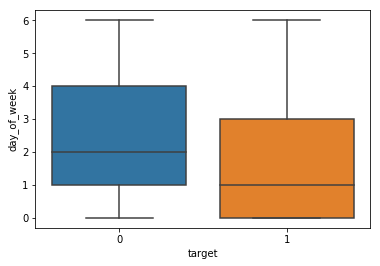

In [237]:
sns.boxplot(x='target', y='day_of_week', data=X_train_poor)

Text(0.5,1,'Others')

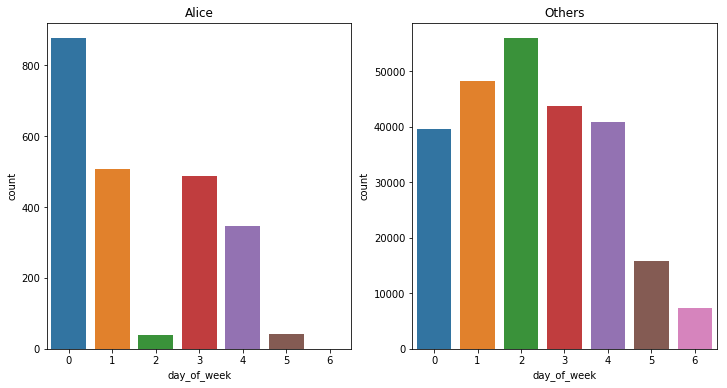

In [239]:
plt.subplots(1, 2, figsize = (12, 6)) 

plt.subplot(1, 2, 1)
sns.countplot(x="day_of_week", data=X_train_poor[X_train_poor['target']==1])
plt.title("Alice")
          
plt.subplot(1, 2, 2)
sns.countplot(x="day_of_week", data=X_train_poor[X_train_poor['target']==0])
plt.title('Others')

Окей, сделаем функцию для заполнения фичи на 7 дней

In [366]:
from sklearn.preprocessing import OneHotEncoder

def add_days_of_week(times, df, is_sprase_matrix = True, DoW_delete = True):
    # сначала сделаем фичу day_of_week, передадим без неё
    day_1 = times['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
    
    # делаем oneHote кодирование
    onehot_encoder = OneHotEncoder(sparse=False)
    ohe = onehot_encoder.fit_transform(day_1)
    # Hardcode, нехорошо
    feature_names =  [0,1,2,3,4,5,6]# ohe.get_feature_names()
    # логика для трейн и спарс матрицы несколько разная
    if is_sprase_matrix:
        objects_to_hstack = [df, ohe]
        if DoW_delete == False: 
            objects_to_hstack.append('day_of_week')
            feature_names = feature_names + ['day_of_week']
        Xray = hstack(objects_to_hstack)
    else:
        Xray = df.copy()
        Xray[list(pd.DataFrame(ohe))] = pd.DataFrame(ohe)
        if DoW_delete == False:
            Xray['day_of_week'] = day_1
            feature_names = feature_names + ['day_of_week']
    return Xray, feature_names


In [367]:
Xray_df,fnames = add_days_of_week(train_times, Xray_df, is_sprase_matrix= False, DoW_delete = True)

In [368]:
Xray_train,z = add_days_of_week(train_times, X_train_prefinal, is_sprase_matrix= True, DoW_delete = True)
Xray_test,z = add_days_of_week(test_times, X_test_prefinal, is_sprase_matrix= True, DoW_delete = True)

In [369]:
fs8 = new_feat_names + ['sess_duration'] + premore_feat_names + fnames
print(fs8)

['morning', 'day', 'evening', 'night', 'sess_duration', 'month', 'year_month', 0, 1, 2, 3, 4, 5, 6]


In [370]:
cv_scores8 = train_and_predict(model=logit, X_train=Xray_train, y_train=y_train, 
                               X_test=Xray_test, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=fs,
                               cv=time_split, submission_file_name='subm8.csv')


CV scores [0.78941651 0.87347319 0.8322363  0.97459511 0.93259028 0.9724054
 0.92178049 0.9590413  0.76026271 0.96876492]
CV mean: 0.8984566212654984, CV std: 0.07588475879133079


Weight?,Feature
+5.068,youwatch.org
+4.970,vk.com
+4.963,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.949,www.express.co.uk
+4.623,www.info-jeunes.net
+4.326,www.melty.fr
+4.305,www.audienceinsights.net
+4.135,fr.glee.wikia.com
+3.887,api.bing.com
+3.816,www.banque-chalus.fr


New feature weights:
          feature      coef
0         morning -1.675015
1             day  2.049836
2         evening -1.946293
3           night  0.000000
4   sess_duration -0.282423
5           month  0.105577
6      year_month -3.224849
7               0  1.608414
8               1  0.716127
9               2 -2.092415
10              3  0.409201
11              4  0.255098
12              5  0.031861
13              6 -2.499757


In [371]:
cv_scores8 > cv_scores7

array([ True,  True, False,  True,  True,  True, False,  True, False,
        True])

Альтернатива: добавим признаки, а не заменим

In [272]:
Xray_train_cv9,z = add_days_of_week(train_times, X_train_final, is_sprase_matrix= True, DoW_delete = True)
Xray_test_cv9,z = add_days_of_week(test_times, X_test_final, is_sprase_matrix= True, DoW_delete = True)

In [270]:
fs9 = new_feat_names + ['sess_duration'] + more_feat_names + fnames
print(fs9)

['morning', 'day', 'evening', 'night', 'sess_duration', 'day_of_week', 'month', 'year_month', 0, 1, 2, 3, 4, 5, 6]


In [372]:
cv_scores9 = train_and_predict(model=logit, X_train=Xray_train_cv9, y_train=y_train, 
                               X_test=Xray_test_cv9, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=fs9,
                               cv=time_split, submission_file_name='subm9.csv')


NameError: name 'Xray_train_cv9' is not defined

In [ ]:
cv_scores9 > cv_scores8

### Попробуем вместо дней недели ввести выхи, где активность Элис минимальна.

In [ ]:
def add_daysof(times, df, is_sprase_matrix = True):
    # в зависимости от дней - выходной или нет. У Элис выходной и в среду
    day_off = times['time1'].apply(lambda t:  1 if (t.weekday() == 2 or t.weekday() == 5 or t.weekday() == 6) else 0).values.reshape(-1, 1)

    feature_names =  ['day_off']
    # логика для трейн и спарс матрицы несколько разная
    if is_sprase_matrix:
        objects_to_hstack = [df, day_off]
        Xray = hstack(objects_to_hstack)
    else:
        Xray = df.copy()
        Xray['day_off'] = Xray['time1'].apply(lambda t:  1 if (t.weekday() == 2 or t.weekday() == 5 or t.weekday() == 6) else 0).values.reshape(-1, 1)
    return Xray, feature_names

In [ ]:
Xray_df,z = add_daysof(train_times, Xray_df, is_sprase_matrix= False)

In [ ]:
Xray_train_10,z = add_daysof(train_times, X_train_prefinal, is_sprase_matrix= True)
Xray_test_10,z = add_daysof(test_times, X_test_prefinal, is_sprase_matrix= True)

In [392]:
fs10 = new_feat_names + ['sess_duration'] + premore_feat_names + z
print(fs10)

['morning', 'day', 'evening', 'night', 'sess_duration', 'month', 'year_month', 0, 1, 2, 3, 4, 5, 6]


In [391]:
cv_scores10 = train_and_predict(model=logit, X_train=Xray_train_10, y_train=y_train, 
                               X_test=Xray_test_10, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=fs10,
                               cv=time_split, submission_file_name='subm10.csv')

CV scores [0.89816956 0.87519137 0.77971774 0.97843559 0.92618827 0.97110535
 0.92887213 0.95503323 0.88125426 0.95993878]
CV mean: 0.9153906272562555, CV std: 0.056936965183808794


Weight?,Feature
+5.207,youwatch.org
+5.017,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.992,vk.com
+4.911,www.express.co.uk
+4.744,www.info-jeunes.net
+4.588,fr.glee.wikia.com
+4.379,www.audienceinsights.net
+4.255,www.melty.fr
+4.091,www.banque-chalus.fr
+3.772,dub119.mail.live.com


New feature weights:
         feature      coef
0        morning -1.671731
1            day  2.009938
2        evening -1.726362
3          night  0.000000
4  sess_duration -0.250448
5          month  0.085832
6     year_month -2.828975
7        day_off -2.363101


In [ ]:
cv_scores10 > cv_scores7

In [ ]:
cv_scores10 > cv_scores8

In [ ]:
cv_scores10 > cv_scores9

In [307]:
cv_means = [np.round(cv_scores.mean(), 5) for cv_scores in [cv_scores1, cv_scores2, cv_scores3, cv_scores4, cv_scores5, 
                                                            cv_scores6, cv_scores7, cv_scores8, cv_scores9,cv_scores10]]
cv_stds = [np.round(cv_scores.std(), 5) for cv_scores in [cv_scores1, cv_scores2, cv_scores3, cv_scores4, cv_scores5, 
                                                            cv_scores6, cv_scores7, cv_scores8, cv_scores9,cv_scores10]]
public_lb_scores = [0.91807, 0.93135, 0.94526, 0.67016, 0.94620, 0.95061, 0.95055, '?', '?', '?']

subm_df = pd.DataFrame({'CV_mean': cv_means, 'CV_std': cv_stds, 'LB': public_lb_scores},
                      index=range(1, len(cv_means) + 1))
subm_df

,CV_mean,CV_std,LB
1,0.86254,0.07456,0.91807
2,0.91676,0.06211,0.93135
3,0.92115,0.04206,0.94526
4,0.62600,0.05292,0.67016
5,0.92101,0.04288,0.9462
6,0.91339,0.06506,0.95061
7,0.91647,0.06410,0.95055
8,0.89884,0.07734,?
9,0.89361,0.08432,?
10,0.91915,0.05663,?


In [373]:
cv_means = [np.round(cv_scores.mean(), 5) for cv_scores in [cv_scores1, cv_scores2, cv_scores3, cv_scores4, cv_scores5, 
                                                            cv_scores6, cv_scores7, cv_scores8, cv_scores9,cv_scores10]]
cv_stds = [np.round(cv_scores.std(), 5) for cv_scores in [cv_scores1, cv_scores2, cv_scores3, cv_scores4, cv_scores5, 
                                                            cv_scores6, cv_scores7, cv_scores8, cv_scores9,cv_scores10]]
public_lb_scores = [0.91807, 0.93135, 0.94526, 0.67016, 0.94620, 0.95061, 0.95055, '?', '?', '?']

subm_df = pd.DataFrame({'CV_mean': cv_means, 'CV_std': cv_stds, 'LB': public_lb_scores},
                      index=range(1, len(cv_means) + 1))
subm_df

,CV_mean,CV_std,LB
1,0.86254,0.07456,0.91807
2,0.91676,0.06211,0.93135
3,0.92115,0.04206,0.94526
4,0.62600,0.05292,0.67016
5,0.92101,0.04288,0.9462
6,0.91337,0.06505,0.95061
7,0.91647,0.06410,0.95055
8,0.89846,0.07588,?
9,0.89463,0.07971,?
10,0.91539,0.05694,?


Попробуем отклабировать

In [383]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l2'],
    'classifier__C' : np.logspace(-4, 4, 30),
    'classifier__solver' : ['liblinear','lbfgs','saga']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10))}
]
pipe = Pipeline([('classifier' , RandomForestClassifier())])
clf2 = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

In [384]:
%%time
clf2.fit(Xray_train_10, y_train); 

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 142.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 205.2min finished


Wall time: 3h 25min 19s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'classifier': [LogisticRegression(C=1.3738237958832638, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start...         warm_start=False)], 'classifier__n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}],
       pre_d

In [388]:
print(clf2.best_score_, clf2.best_params_)
final2_model = clf2.best_estimator_

0.9911618900382946 {'classifier': LogisticRegression(C=1.3738237958832638, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), 'classifier__C': 1.3738237958832638, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


In [397]:
print(Xray_train_10.shape)
print(Xray_test_10.shape)
print(X_train_prefinal.shape)

print(y_train.shape)

(253561, 50008)
(82797, 50008)
(253561, 50007)
(253561,)


In [400]:
fs10 = new_feat_names + ['sess_duration'] + premore_feat_names + ['day_off']
print(fs10)

['morning', 'day', 'evening', 'night', 'sess_duration', 'month', 'year_month', 'day_off']


In [403]:
final3_model = LogisticRegression(C= 1.3738237958832638, random_state=SEED, solver='liblinear', penalty = 'l2')

In [404]:
cv_scores11 = train_and_predict(model=final3_model, X_train=Xray_train_10, y_train=y_train, 
                               X_test=Xray_test_10, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=fs10,
                               cv=time_split, submission_file_name='subm11.csv')

CV scores [0.90517514 0.87315472 0.78001446 0.97903695 0.92793206 0.97089709
 0.9311226  0.9545178  0.88729213 0.96039242]
CV mean: 0.9169535367096483, CV std: 0.05663279447043462


Weight?,Feature
+6.483,www.express.co.uk
+6.177,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.373,youwatch.org
+5.118,vk.com
+5.015,fr.glee.wikia.com
+4.935,www.info-jeunes.net
+4.561,www.banque-chalus.fr
+4.539,www.audienceinsights.net
+4.435,www.melty.fr
+4.243,browser-update.org


New feature weights:
         feature      coef
0        morning -1.625786
1            day  2.071429
2        evening -1.871345
3          night  0.000000
4  sess_duration -0.234165
5          month  0.089312
6     year_month -2.918546
7        day_off -2.377785


In [406]:
cv_means = [np.round(cv_scores.mean(), 5) for cv_scores in [cv_scores1, cv_scores2, cv_scores3, cv_scores4, cv_scores5, 
                                                            cv_scores6, cv_scores7, cv_scores8, cv_scores9,cv_scores10,
                                                           cv_scores11]]
cv_stds = [np.round(cv_scores.std(), 5) for cv_scores in [cv_scores1, cv_scores2, cv_scores3, cv_scores4, cv_scores5, 
                                                            cv_scores6, cv_scores7, cv_scores8, cv_scores9,cv_scores10,
                                                         cv_scores11]]
public_lb_scores = [0.91807, 0.93135, 0.94526, 0.67016, 0.94620, 0.95061, 0.95055, '?', '?', 0.94900, 0.94800]

subm_df = pd.DataFrame({'CV_mean': cv_means, 'CV_std': cv_stds, 'LB': public_lb_scores},
                      index=range(1, len(cv_means) + 1))
subm_df

,CV_mean,CV_std,LB
1,0.86254,0.07456,0.91807
2,0.91676,0.06211,0.93135
3,0.92115,0.04206,0.94526
4,0.62600,0.05292,0.67016
5,0.92101,0.04288,0.9462
6,0.91337,0.06505,0.95061
7,0.91647,0.06410,0.95055
8,0.89846,0.07588,?
9,0.89463,0.07971,?
10,0.91539,0.05694,0.949


## Ход конем: в качестве экспереминента пнем Catboost и посмотрим на его результат

50008


(253561, 50008)

In [420]:
Xray_train_10_part, Xray_train_10_valid, y_train_part, y_valid = train_test_split(Xray_train_10, y_train, 
                                                                test_size=0.3, 
                                                                random_state=17)

In [424]:
import xgboost as xgb
dtrain = xgb.DMatrix(Xray_train_10_part, label = y_train_part )
dtest = xgb.DMatrix(Xray_train_10_valid, label = y_valid)

In [425]:
%%time
param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)
roc_auc_score(y_valid, preds)

Wall time: 929 ms


In [ ]:
# make prediction


In [429]:
from xgboost import XGBClassifier
xgb2 = XGBClassifier(n_estimators=100)
xgb2.fit(Xray_train_10_part, y_train_part)
preds2 = xgb2.predict(Xray_train_10_valid)
roc_auc_score(y_valid, preds2)

0.5835511830492849

In [427]:
roc_auc_score(y_valid, preds)

0.6703083270020602

### Время для пары новых фич.
- Фича - сигнал о выходных?
- Признак долгой сессии - Элис не очень то их и жалует
- Количество сайтов посещаемых за одну сессию
- Временной период (в значениях, что Элис не заходила например осенью 2015)

In [ ]:
cv_scores7 = train_and_predict(model=final_model, X_train=X_train_final, y_train=y_train, 
                               X_test=X_test_final, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'] + more_feat_names,
                               cv=time_split, submission_file_name='subm7.csv')

## Conclusions
 - keep track of cross-validation improvements for *each* fold (or at least as many folds as possible)
 - take a look at cross-validation std, not only mean
 - try to build a CV scheme so that CV improvements correlate with LB improvements (it's very important)
 - exploring feature importance might help, sometimes even in detecting overfitting
 - spend most of the competition time exploring data and building features
 
Good luck!

<img src="https://habrastorage.org/webt/ai/xu/sy/aixusyqysuiou9rsll7x909jyw0.jpeg" width=50% /> 
*<div style="text-align: center"> image credit <a href='http://www.alicekristiansen.com/'>www.alicekristiansen.com</a> </div>*
